In [5]:
import numpy as np
import plotly.graph_objects as go
import random
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.problems import get_problem
from pymoo.util.plotting import plot
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize


In [6]:
def dominance_matrix_diff(a, b):
    diff = np.array(a) - np.array(b)
    
    if np.all(diff >= 0) and not np.array_equal(a, b):
        return 1
    else:
        return 0
    
def get_dominance_matrix(coordinates):
    dominance_matrix = np.zeros((len(coordinates), len(coordinates)))
    for i, elem1 in enumerate(coordinates):
        for j, elem2 in enumerate(coordinates):
            dominance_matrix[i,j] = dominance_matrix_diff(elem1, elem2)
    return dominance_matrix

def plot_pareto_fronts(frentes):
    """
    Grafica los frentes de Pareto a partir de una lista de arrays de numpy.
    
    Args:
        frentes (list): Lista de arrays de numpy, donde cada array contiene puntos pertenecientes a un frente.
    """
    colores = ["red", "blue", "green", "purple", "orange", "brown", "pink", "gray"]

    plt.figure(figsize=(10, 6))

    for idx, (pts, color) in enumerate(zip(frentes, colores), start=1):
        plt.scatter(pts[:, 0], pts[:, 1], color=color, label=f"Frente {idx}", s=100)

    # Configuración de la gráfica
    plt.title('Frentes de Pareto')
    plt.xlabel('Objetivo f1(x)')
    plt.ylabel('Objetivo f2(x)')
    plt.legend()
    plt.show()

# def plot_pareto_fronts_3d(frentes):
#     """
#     Grafica los frentes de Pareto en 3D a partir de una lista de arrays de numpy. (con matplotlib) NO INTERACTIVO

#     Args:
#         frentes (list): Lista de arrays de numpy, donde cada array contiene puntos pertenecientes a un frente.
#                         Cada punto debe tener tres coordenadas para los objetivos.
#     """
#     colores = ["red", "blue", "green", "purple", "orange", "brown", "pink", "gray"]

#     fig = plt.figure(figsize=(10, 8))
#     ax = fig.add_subplot(111, projection='3d')

#     for idx, (pts, color) in enumerate(zip(frentes, colores), start=1):
#         ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], color=color, label=f"Frente {idx}", s=50)

#     # Configuración de la gráfica
#     ax.set_title('Frentes de Pareto en 3D')
#     ax.set_xlabel('Objetivo f1(x)')
#     ax.set_ylabel('Objetivo f2(x)')
#     ax.set_zlabel('Objetivo f3(x)')
#     ax.legend()

#     plt.show()

def plot_pareto_fronts_3d(frentes):
    """
    Grafica los frentes de Pareto en 3D a partir de una lista de arrays de numpy utilizando Plotly.

    Args:
        frentes (list): Lista de arrays de numpy, donde cada array contiene puntos pertenecientes a un frente.
                        Cada punto debe tener tres coordenadas para los objetivos.
    """
    colores = ["red", "blue", "green", "purple", "orange", "brown", "pink", "gray"]

    fig = go.Figure()

    for idx, (pts, color) in enumerate(zip(frentes, colores), start=1):
        fig.add_trace(go.Scatter3d(
            x=pts[:, 0],
            y=pts[:, 1],
            z=pts[:, 2],
            mode='markers',
            marker=dict(size=5, color=color),
            name=f"Frente {idx}"
        ))

    # Configuración de la gráfica
    fig.update_layout(
        title="Frentes de Pareto en 3D",
        scene=dict(
            xaxis_title="Objetivo f1(x)",
            yaxis_title="Objetivo f2(x)",
            zaxis_title="Objetivo f3(x)"
        ),
        legend=dict(title="Frentes")
    )

    fig.show()

def get_pareto_fronts(coordinates):
    coordinates_copy = coordinates.copy()
    fronts = []

    while len(coordinates_copy) > 1:
        dominance_matrix = get_dominance_matrix(coordinates_copy)
        dominated_count = dominance_matrix.sum(axis=0)
        current_front = np.where(dominated_count == 0)[0]
        pareto_points = coordinates_copy[current_front]
        fronts.append(pareto_points)
        coordinates_copy = np.delete(coordinates_copy, (current_front), axis=0)

    return fronts

def calcular_distancia_crowding(frente):
    """
    Calcula las distancias de crowding para un frente de Pareto.

    Args:
        frente (np.ndarray): Array de puntos (n x m), donde n es el número de puntos y m el número de objetivos.

    Returns:
        list: Lista de distancias de crowding para cada punto del frente.
    """
    n_puntos = len(frente)
    if n_puntos < 2:
        # Si hay menos de dos puntos, no se puede calcular crowding
        return [float('inf')] * n_puntos

    # Inicializar las distancias de crowding
    distancia_frente = [0] * n_puntos

    for k in range(frente.shape[1]):  # Para cada objetivo
        # Ordenar los puntos según el objetivo k
        args = np.argsort(frente[:, k])

        # Asignar infinito a los extremos
        distancia_frente[args[0]] = float('inf')
        distancia_frente[args[-1]] = float('inf')

        # Calcular contribuciones para los puntos internos
        for i in range(1, n_puntos - 1):
            distancia_frente[args[i]] += (
                (frente[args[i + 1], k] - frente[args[i - 1], k]) /
                (frente[args[-1], k] - frente[args[0], k])
                if frente[args[-1], k] != frente[args[0], k] else 0
            )

    return distancia_frente

def get_crowding_distances(fronts):
    distancias = []
    for frente in fronts:
        distancias.append(calcular_distancia_crowding(frente))
    return distancias

(1000, 2)


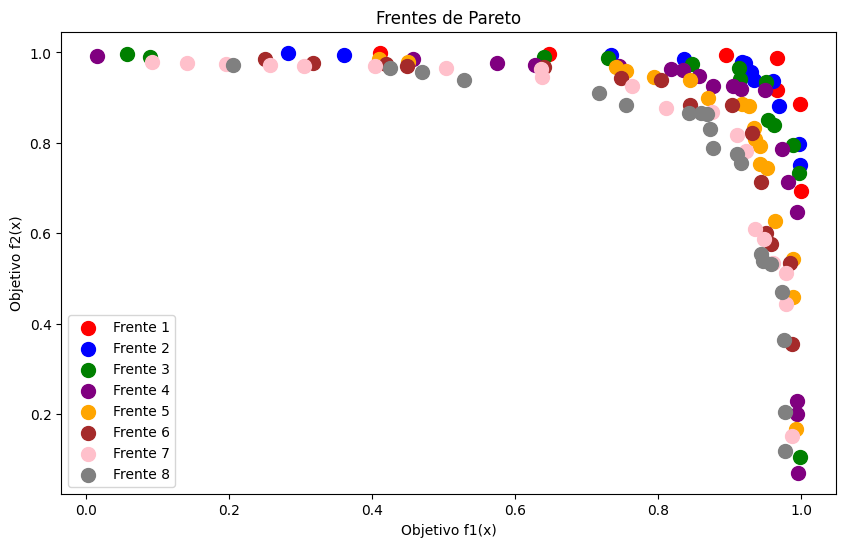

In [7]:
num_points = 1000
dim = 2

# coordinates = np.random.randint(0, 100, (num_points, dim))
coordinates = np.random.random((num_points, dim))
print(coordinates.shape)

fronts = get_pareto_fronts(coordinates)

distances = get_crowding_distances(fronts)
# print(distances)
plot_pareto_fronts(fronts)

In [8]:
num_points = 1000
dim = 3

# coordinates = np.random.randint(0, 100, (num_points, dim))
coordinates = np.random.random((num_points, dim))
print(coordinates.shape)

fronts = get_pareto_fronts(coordinates)

distances = get_crowding_distances(fronts)
# print(distances)
plot_pareto_fronts_3d(fronts)

(1000, 3)
